In [ ]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../thesis.mplstyle')

In [ ]:
def WALL_time_to_seconds(s):
    """
    Transform string of CPU/WALL time in output files of QE
    to time in seconds
    """
    
    # Remove extra spaces
    s = s.strip().replace(" ", "")
    # Extract hours, minutes, seconds using regex
    hours = re.search(r"(\d+(?:\.\d+)?)h", s)
    minutes = re.search(r"(\d+(?:\.\d+)?)m", s)
    seconds = re.search(r"(\d+(?:\.\d+)?)s", s)

    h = float(hours.group(1)) * 3600 if hours else 0
    m = float(minutes.group(1)) * 60 if minutes else 0
    s = float(seconds.group(1)) if seconds else 0

    return h + m + s

# Cut-off energy

In [ ]:
def read_ecut(directory):
    """
    Analysis of convergence with varying cutoff energy.
    Read output file of QE.
    Args:
    - directory: directory with input and output files

    Output:
    - cutoff energies (np.array)
    - scf total energies (np.array)
    - cpu-time in seconds (np.array)
    """

    output_files = [x for x in os.listdir(directory) if x.endswith('out')]
    cutoff_energy = []
    scf_energy = []
    times = []
    for filename in output_files:
        filepath = os.path.join(directory, filename)

        with open(filepath, 'r') as f:
            for line in f.readlines():
                if line.startswith('     Number of MPI processes:'):
                    nmpis = int(line.split(':')[1].split(' ')[-1])
                if line.startswith('     kinetic-energy cutoff'):
                    cutoff = float(line.split('=')[1].split(' ')[-3])
                    cutoff_energy.append(cutoff)
                if line.startswith('!    total energy'):
                    total = float(line.split('=')[1].split(' ')[-2])
                    scf_energy.append(total)
                if line.startswith('     PWSCF        :'):
                    time = WALL_time_to_seconds(line.split('CPU')[1].split('WALL')[0])
                    time *= nmpis
                    times.append(time)

    cutoff_energy = np.array(cutoff_energy)
    scf_energy = np.array(scf_energy)
    times = np.array(times)
    idxs = np.argsort(cutoff_energy)

    return cutoff_energy[idxs], scf_energy[idxs], times[idxs]

In [4]:
ecutDir = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAG/LDA/ecut'
cutoff_energy, scf_energy, times = read_ecut(ecutDir)

In [ ]:
def plot_etotal_cutoff(cutoff_energy, scf_energy, ax=None, **kwargs):
    """
    Plot convergence of total energy with varying cutoff energy.
    Args:
    - cutoff_energy: array with values of cut off energies
    - scf_energy: array with values of total energies
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure
    
    ax.plot(cutoff_energy, scf_energy, **kwargs)
    ax.set_xlabel('Energía de corte [Ry]')
    ax.set_ylabel('Energía total [Ry]')

def plot_ediff_cutoff(cutoff_energy, scf_energy, threshold=1e-4, ax=None, **kwargs):
    """
    Plot difference of total energy of consecutive cutoff energies.
    Args:
    - cutoff_energy: array with values of cut off energies
    - scf_energy: array with values of total energies
    - threshold=1e-4: horizontal line of upper limit
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure
    
    energy_diff = np.abs(scf_energy[1:] - scf_energy[:-1])
    ax.plot(cutoff_energy[1:], energy_diff, **kwargs)
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
              linestyle='--', color='#9e9e9e')
    ax.set_xlabel('Energía de corte [Ry]')
    ax.set_ylabel(r'$\Delta E_\text{cut}$ [Ry]')
    ax.set_yscale('log')

def plot_times(x, times, ax=None, **kwargs):
    """
    Plot cpu-times
    Args:
    - x: array with values of parameter
    - times: array with cpu-times in seconds
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure
    
    # time in hours
    ax.plot(x, times/3600, **kwargs)
    ax.set_ylabel('CPU-time [CPU-horas]')

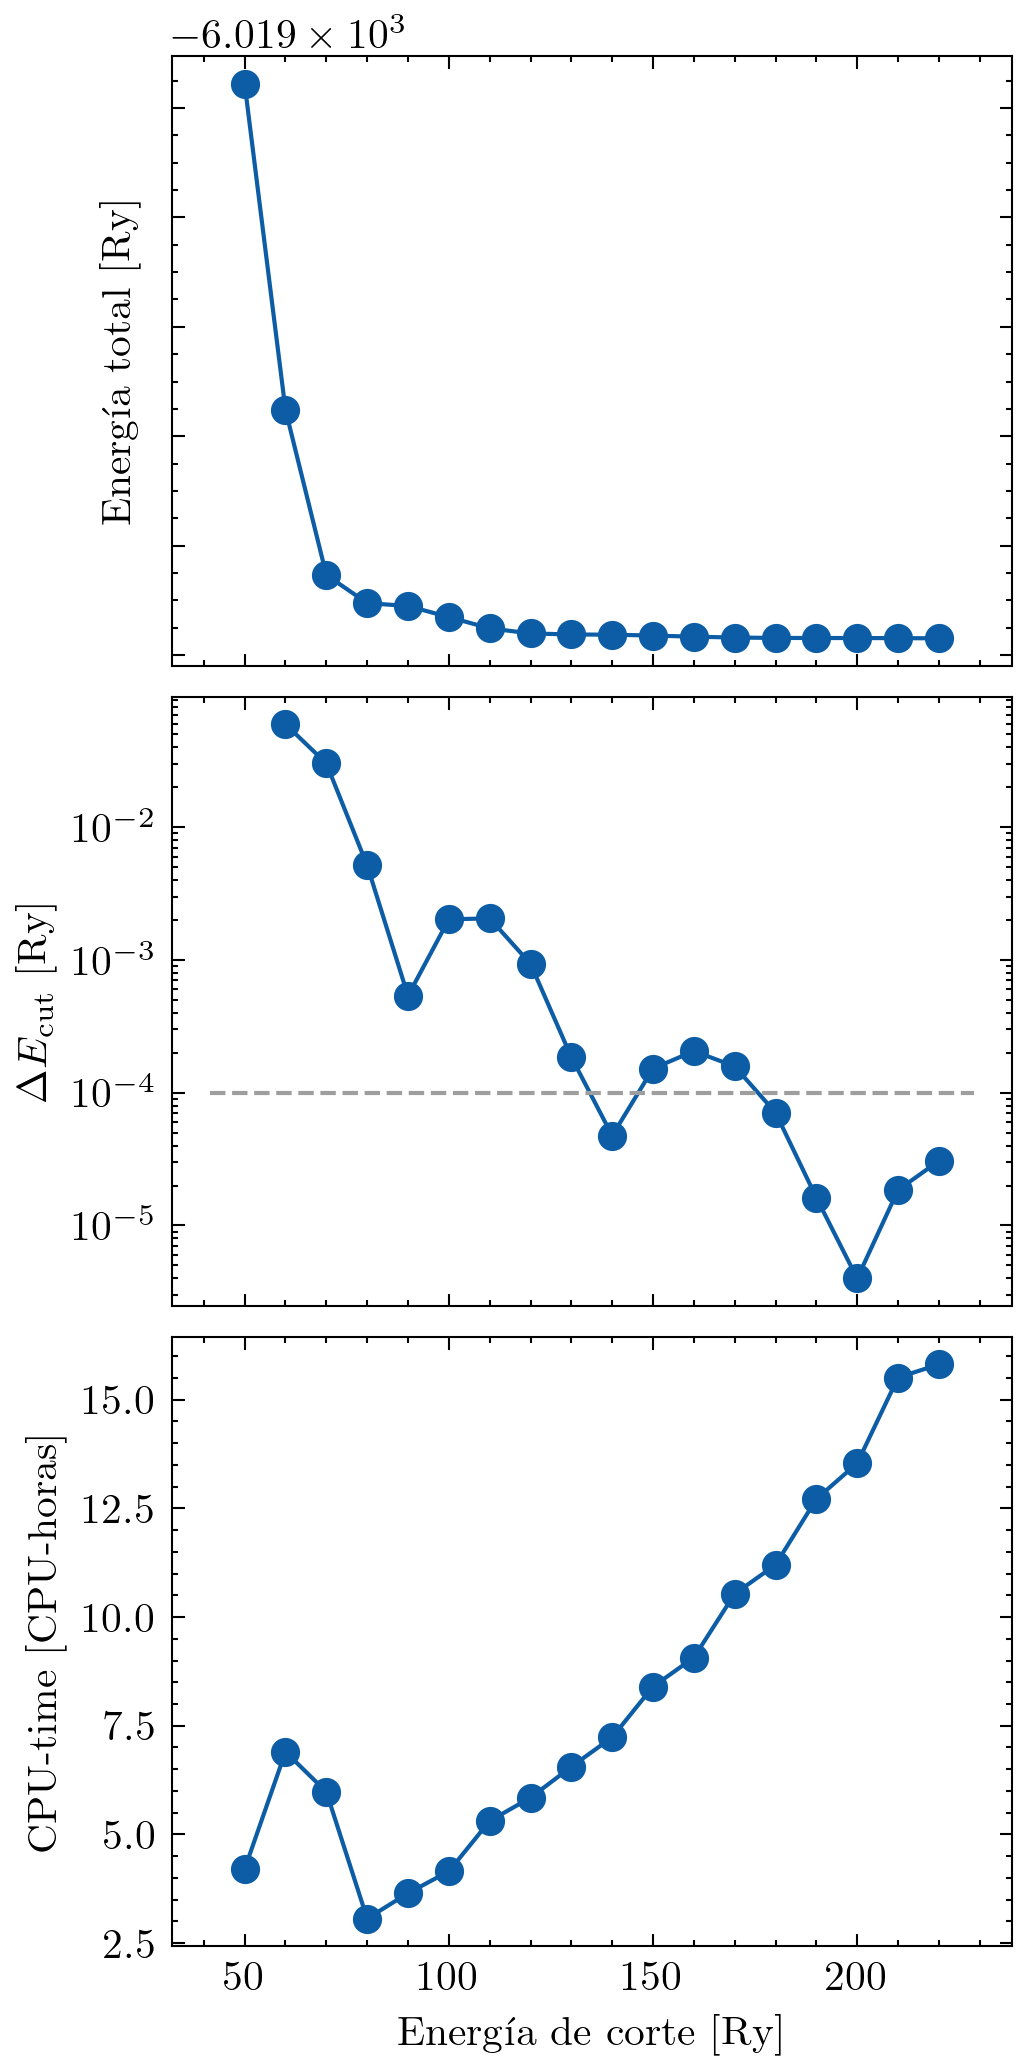

In [6]:
fig = plt.figure(figsize=(3.5, 2.625*3), dpi=300)

gs1 = gridspec.GridSpec(3, 1)
gs1.update(left=0.1, right=0.9, wspace=0.025, hspace=0.05, bottom=0.1, top=0.9)

ax2 = plt.subplot(gs1[2, 0])
plot_times(cutoff_energy, times, ax=ax2, ls='solid', marker='o')
ax2.set_xlabel('Energía de corte [Ry]')

ax1 = plt.subplot(gs1[1, 0], sharex=ax2)
plt.setp(ax1.get_xticklabels(), visible=False)
plot_ediff_cutoff(cutoff_energy, scf_energy, ax=ax1, ls='solid', marker='o')
ax1.set_xlabel('')

ax0 = plt.subplot(gs1[0, 0], sharex=ax2)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax0.get_yticklabels(), visible=False)
plot_etotal_cutoff(cutoff_energy, scf_energy, ax=ax0, ls='solid', marker='o')
ax0.set_xlabel('')

plt.show()

# k-points sampling

In [ ]:
def read_kpoints(directory):
    """
    Analysis of convergence with varying number of kpoints.
    Read input and output file of QE.
    Args:
    - directory: directory with input and output files

    Output:
    - kpoints (k1, k2, k3) (2D np.array)
    - scf total energies (np.array)
    - cpu-time in seconds (np.array)
    """

    output_files = [x for x in os.listdir(directory) if x.endswith('out')]
    input_files = [x[:-3]+'in' for x in output_files]

    kpoints =[]
    scf_energy = []
    times = []

    for ifile, ofile in zip(input_files, output_files):
        ifilepath = os.path.join(directory, ifile)

        with open(ifilepath, 'r') as f:
            read = False
            for line in f.readlines():
                if line.startswith('K_POINTS'): 
                    read = True
                    continue
                if line.startswith('CELL_PARAMETERS'):
                    break
                if read:
                    kp = line.split(' ')
                    kp = [k for k in kp if len(kp)>0]
                    kp = kp[:3]
                    kp = [int(k) for k in kp]
                    kpoints.append(kp)

        ofilepath = os.path.join(directory, ofile)
        with open(ofilepath, 'r') as f:
            for line in f.readlines():
                if line.startswith('     Number of MPI processes:'):
                    nmpis = int(line.split(':')[1].split(' ')[-1])
                if line.startswith('!    total energy'):
                    total = float(line.split('=')[1].split(' ')[-2])
                    scf_energy.append(total)
                if line.startswith('     PWSCF        :'):
                    time = WALL_time_to_seconds(line.split('CPU')[1].split('WALL')[0])
                    time *= nmpis
                    times.append(time)

    kpoints = np.array(kpoints)
    scf_energy = np.array(scf_energy)
    times = np.array(times)
    idxs = np.argsort(kpoints[:,0])

    return kpoints[idxs], scf_energy[idxs], times[idxs]

In [8]:
kpDir = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAP/LDA/kpoints'
kpoints, scf_energy, times = read_kpoints(kpDir)

In [ ]:
def plot_etotal_kpoints(kpoints, scf_energy, ax=None, **kwargs):
    """
    Plot convergence of total energy with varying number of kpoints.
    Args:
    - kpoints: array with values of kpoints
    - scf_energy: array with values of total energies
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure

    x = np.arange(kpoints.shape[0])
    ax.plot(x, scf_energy, **kwargs)
    ax.set_xticks(x, [f"({int(i)},{int(j)},{int(k)})" for (i,j,k) in kpoints])
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_xlabel(r'$(k_1,k_2,k_3)$')
    ax.set_ylabel('Energía total [Ry]')

def plot_ediff_kpoints(kpoints, scf_energy, threshold=1e-4, ax=None, **kwargs):
    """
    Plot difference of total energy of consecutive kpoints.
    Args:
    - kpoints: array with values of kpoints
    - scf_energy: array with values of total energies
    - threshold=1e-4: horizontal line of upper limit
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure
    
    x = np.arange(kpoints.shape[0])
    energy_diff = np.abs(scf_energy[1:] - scf_energy[:-1])
    ax.plot(x[1:], energy_diff, **kwargs)
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
              linestyle='--', color='#9e9e9e')
    ax.set_xticks(x, [f"({int(i)},{int(j)},{int(k)})" for (i,j,k) in kpoints])
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_xlabel(r'$(k_1,k_2,k_3)$')
    ax.set_ylabel(r'$\Delta E_\text{cut}$ [Ry]')
    ax.set_yscale('log')

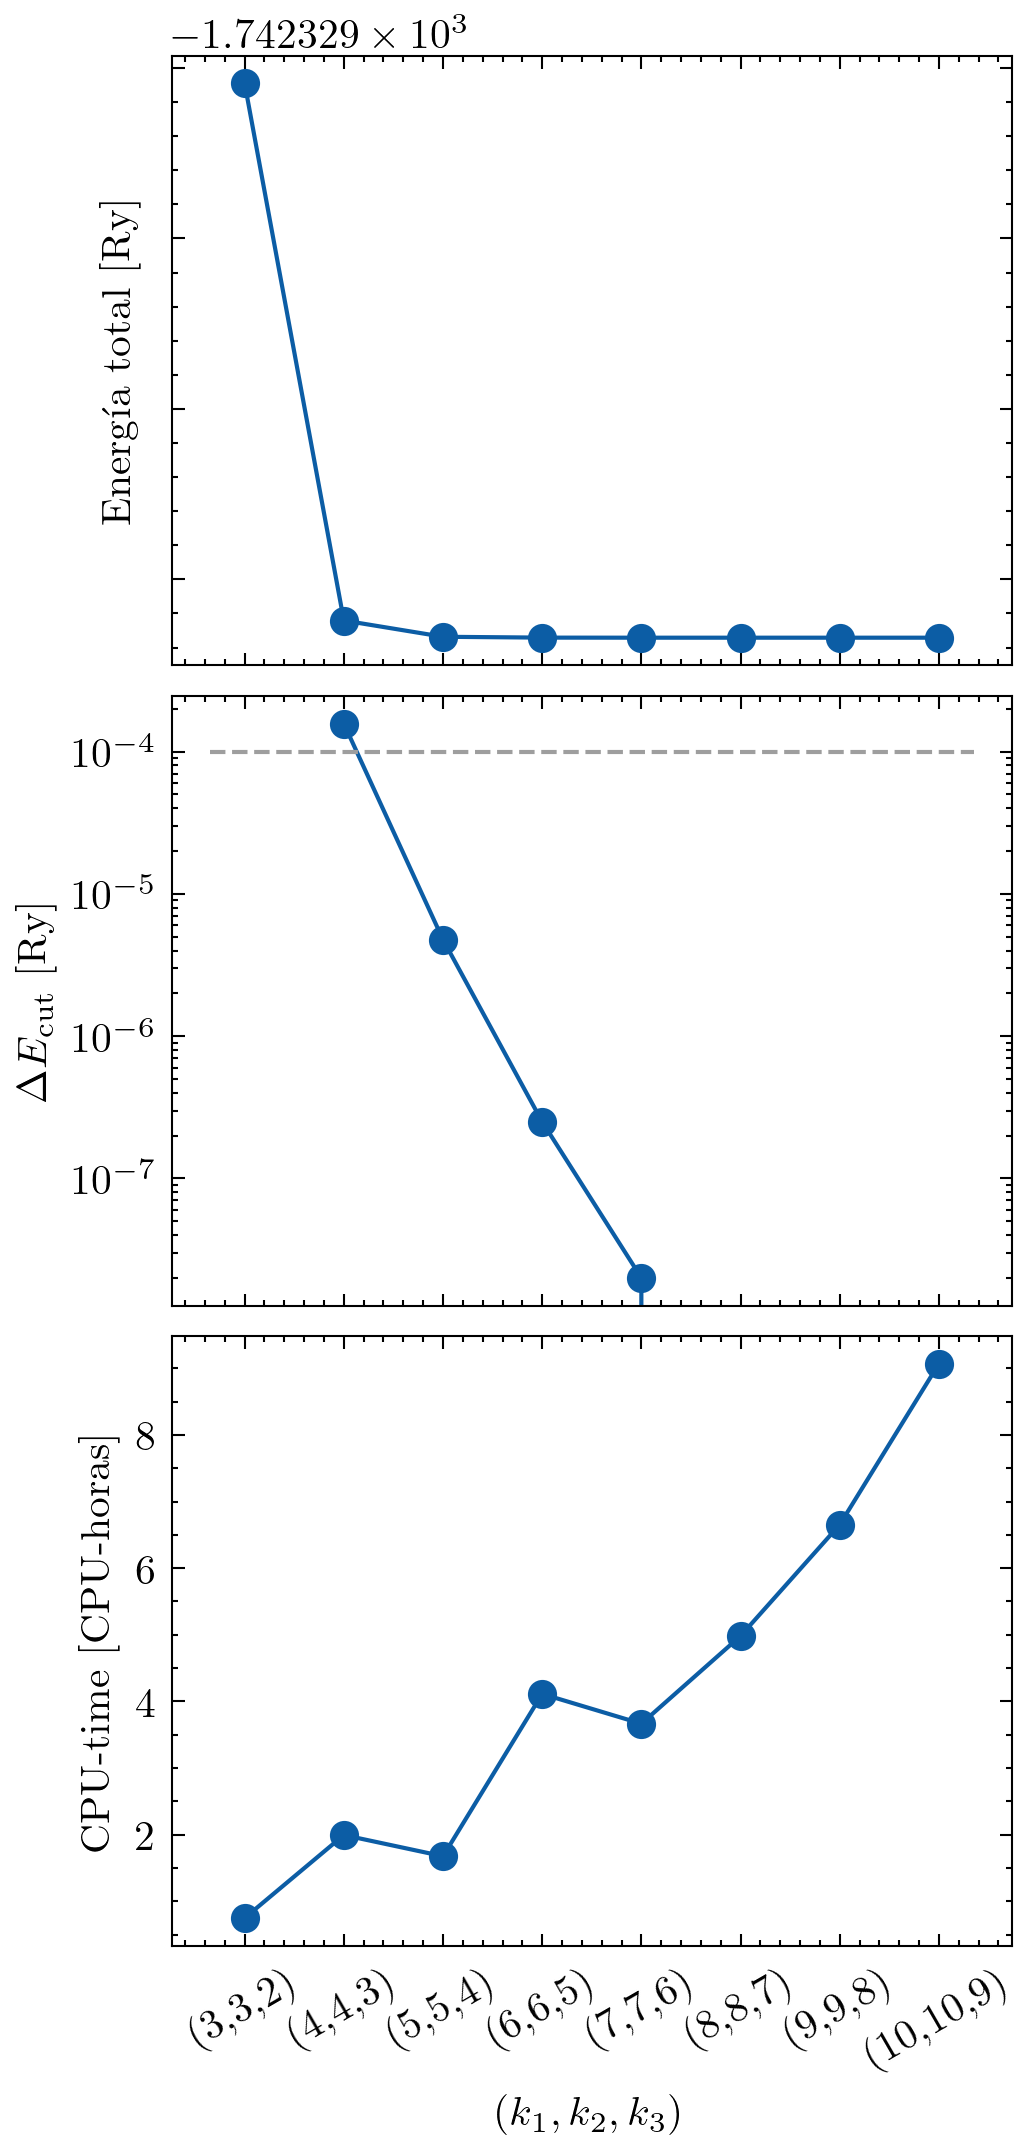

In [10]:
fig = plt.figure(figsize=(3.5, 2.625*3), dpi=300)

gs1 = gridspec.GridSpec(3, 1)
gs1.update(left=0.1, right=0.9, wspace=0.025, hspace=0.05, bottom=0.1, top=0.9)

ax2 = plt.subplot(gs1[2, 0])
plot_times(np.arange(kpoints.shape[0]), times, ax=ax2, ls='solid', marker='o')
ax2.set_xticks(np.arange(kpoints.shape[0]), [f"({int(i)},{int(j)},{int(k)})" for (i,j,k) in kpoints])
ax2.tick_params(axis='x', labelrotation=30)
ax2.set_xlabel(r'$(k_1,k_2,k_3)$')

ax1 = plt.subplot(gs1[1, 0], sharex=ax2)
plt.setp(ax1.get_xticklabels(), visible=False)
plot_ediff_kpoints(kpoints, scf_energy, ax=ax1, ls='solid', marker='o')
ax1.set_xlabel('')

ax0 = plt.subplot(gs1[0, 0], sharex=ax2)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax0.get_yticklabels(), visible=False)
plot_etotal_kpoints(kpoints, scf_energy, ax=ax0, ls='solid', marker='o')
ax0.set_xlabel('')

plt.show()

# Geometric optimization

In [ ]:
def read_input_rlx(input_file):
    """
    Read input file of QE for geometric optimization
    to extract initial cell parameters, atomic coordinates,
    and atom labels.
    Args:
    - input_file: path to input file (vc-relax)

    Output:
    - cell parameters or lattice vectors (2D np.array)
    - xyz coordinates of atoms (2D np.array)
    - atomic labels (list)
    """

    # read input file
    inlines = open(input_file, 'r').readlines()
    extract = False
    selected_lines = []
    for line in inlines:
        # extract relevant information
        if extract: 
            tokens = []
            for x in line.split(' '):
                if x.endswith('\n'): x = x[:-2] # avoid linejumps
                if len(x)==0: continue  # avoid blank spaces
                tokens.append(x)
            selected_lines.append(tokens)

        if line.startswith('ATOMIC_POSITIONS'):
            extract = True
        elif line.startswith('K_POINTS'):
            extract = False
        elif line.startswith('CELL_PARAMETERS'):
            extract = True

    # initial cell vectors
    cell_parameters = np.array([[float(x) for x in y] for y in selected_lines[-3:]])

    # atomic labels
    _labels = [x[0] for x in selected_lines[:-4]]   # chemical symbol
    labels = []
    # label = chemical symbol + atom index
    for i in range(len(_labels)):
        labels.append(_labels[i] + str(_labels[:i+1].count(_labels[i])))

    # initial coordinates
    xyz = np.array([[float(x) for x in y[1:]] for y in selected_lines[:-4]])
    xyz = np.matmul(xyz, cell_parameters)
    return cell_parameters, xyz, labels

def read_output_rlx(output_file):
    """
    Read output file of QE for geometric optimization
    to extract final cell parameters, atomic coordinates,
    and atom labels.
    Args:
    - output_file: path to output file (vc-relax)

    Output:
    - cell parameters or lattice vectors (2D np.array)
    - xyz coordinates of atoms (2D np.array)
    - atomic labels (list)
    """

    # read output file
    inlines = open(output_file, 'r').readlines()
    extract = False
    outlines = []
    for line in inlines:
        # extract final coordinates
        if extract: outlines.append(line)

        if line.startswith('Begin final coordinates'):
            extract = True
        elif line.startswith('End final coordinates'):
            extract = False

    selected_lines = []
    for line in outlines[:-1]:
        # extract relevant information
        if extract: 
            tokens = []
            for x in line.split(' '):
                if x.endswith('\n'): x = x[:-2] # avoid linejumps
                if len(x)==0: continue  # avoid blank spaces
                tokens.append(x)
            selected_lines.append(tokens)

        if line.startswith('CELL_PARAMETERS'):
            extract = True

    # final cell vectors
    cell_parameters = np.array([[float(x) for x in y] for y in selected_lines[:3]])

    # atomic labels
    _labels = [x[0] for x in selected_lines[5:]]   # chemical symbol
    labels = []
    # label = chemical symbol + atom index
    for i in range(len(_labels)):
        labels.append(_labels[i] + str(_labels[:i+1].count(_labels[i])))

    # final coordinates
    xyz = np.array([[float(x) for x in y[1:]] for y in selected_lines[5:]])
    xyz = np.matmul(xyz, cell_parameters)
    
    return cell_parameters, xyz, labels

def read_energies_forces_rlx(output_file):
    """
    Read output file of QE for geometric optimization
    to extract cell parameters, energies, and forces
    for each iteration
    Args:
    - output_file: path to output file (vc-relax)

    Output:
    - cell parameters or lattice vectors for each iteration (3D np.array)
    - energies (np.array)
    - forces (np.array)
    """

    # read output file
    inlines = open(output_file, 'r').readlines()
    extract_coor = False
    outlines = []
    energies = []
    forces = []
    for line in inlines:
        if line.startswith('CELL_PARAMETERS (angstrom)'):
            extract_coor = True
            continue
        elif line.startswith('ATOMIC_POSITIONS (crystal)'):
            extract_coor = False
            continue
        elif line.startswith('!    total energy'):
            tokens = [x for x in line.split(' ') if len(x)!=0]
            energies.append(float(tokens[-2]))
        elif line.startswith('     Total force'):
            tokens = [x for x in line.split(' ') if len(x)!=0]
            forces.append(float(tokens[3]))

        # extract final coordinates
        if extract_coor: 
            if line.endswith('\n'): line = line[:-2]
            if len(line)==0: continue
            outlines.append(line)

    cell_parameters = [[float(x) for x in y.split(' ') if len(x)!=0] for y in outlines]
    cell_parameters = [[cell_parameters[i*3], cell_parameters[i*3+1], cell_parameters[i*3+2]] for i in range(len(cell_parameters)//3)]
    cell_parameters = np.array(cell_parameters)

    energies = np.array(energies)
    forces = np.array(forces)
    
    return cell_parameters, energies, forces

In [12]:
input_file = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAM/LDA/YAM.rlx.in'
output_file = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAM/LDA/YAM.rlx.out'

A_initial, xyz_initial, Z_initial = read_input_rlx(input_file)
A, xyz, Z = read_output_rlx(output_file)
A_iterations, energies, forces = read_energies_forces_rlx(output_file)

In [13]:
# lattice vectors
A

array([[ 7.26455486e+00,  0.00000000e+00,  1.66967000e-03],
       [ 0.00000000e+00,  1.03395044e+01,  0.00000000e+00],
       [-3.48554227e+00,  0.00000000e+00,  1.04216028e+01]])

In [ ]:
def plot_energy_rlx(energies, ax=None, **kwargs):
    """
    Plot difference of the energy calculated at each iteration
    and the minimum energy obtained at the end of the optimization.
    Args:
    - energies: array of energies
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure

    x = np.arange(len(energies))
    y = energies - energies.min()
    ax.plot(x, y*1e3, **kwargs)
    ax.set_ylabel(r'$\Delta E$ [mRy]')
    ax.set_xlabel('Iteración')

def plot_force_rlx(forces, ax=None, **kwargs):
    """
    Plot difference of the force calculated at each iteration
    and the minimum force obtained at the end of the optimization.
    Args:
    - forces: array of energies
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure

    x = np.arange(len(forces))
    y = forces - forces.min()
    ax.plot(x, y*1e3, **kwargs)
    ax.set_ylabel(r'Fuerza neta [mRy/$a_0$]')
    ax.set_xlabel('Iteración')

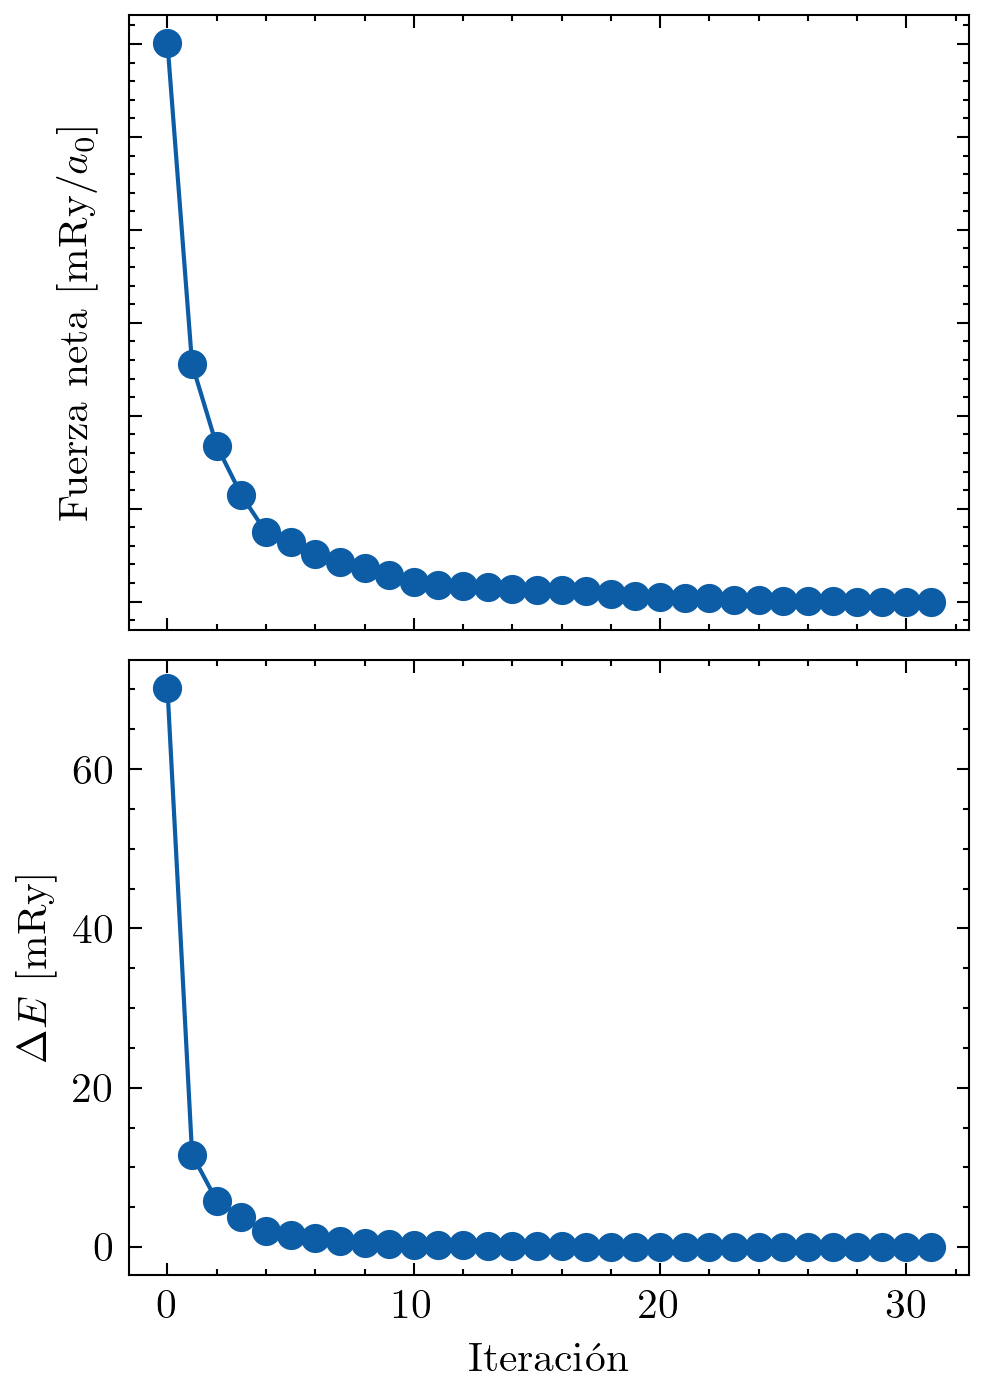

In [15]:
fig = plt.figure(figsize=(3.5, 2.625*2), dpi=300)

gs1 = gridspec.GridSpec(2, 1)
gs1.update(left=0.1, right=0.9, wspace=0.025, hspace=0.05, bottom=0.1, top=0.9)

ax1 = plt.subplot(gs1[1, 0])
plot_energy_rlx(energies, ax=ax1, ls='solid', marker='o')

ax0 = plt.subplot(gs1[0, 0], sharex=ax1)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax0.get_yticklabels(), visible=False)
plot_force_rlx(forces, ax=ax0, ls='solid', marker='o')
ax0.set_xlabel('')

plt.show()

In [16]:
def get_bond_length(atom1, atom2, xyz, Z):
    # indices of atoms
    i1 = Z.index(atom1)
    i2 = Z.index(atom2)
    # coordinates of atoms
    xyz1 = xyz[i1, :]
    xyz2 = xyz[i2, :]
    # vector from atom1 to atom2
    d = xyz2 - xyz1
    return np.linalg.norm(d)

In [17]:
d = get_bond_length('Y13', 'O31', xyz, Z)
print(d)

2.329133378336667


# SCF Energy

In [ ]:
def read_output_scf(output_file):
    """
    Read output of scf energy calculation
    to extract energy contributions to
    total energy.
    Args:
    - output_file: path to output file

    Output:
    - (h0Ene, hartreeEne, xcEne, ewaldEne, pawEne) in a np.array
    """

    outlines = open(output_file, 'r').readlines()

    select = False
    eTerms = []
    contributions = ['!', 'one-electron', 'hartree', 'xc', 'ewald', 'one-center']
    for line in outlines:
        if line.startswith('!'): select = True
        if line.startswith('     convergence has been achieved'): select = False
        if not select: continue
        tokens = [x for x in line.split(' ') if len(x)>0]
        if tokens[0] not in contributions: continue
        eTerms.append(float(tokens[-2]))

    total = eTerms[0]
    h0Ene, hartreeEne, xcEne, ewaldEne, pawEne = eTerms[1:]

    print('One-Electron:', h0Ene)
    print('   + Hartree:', h0Ene+hartreeEne)
    print('        + XC:', h0Ene+hartreeEne+xcEne)
    print('     + Ewald:', h0Ene+hartreeEne+xcEne+ewaldEne)
    print('       + PAW:', h0Ene+hartreeEne+xcEne+ewaldEne+pawEne)
    print('Total Energy: ', total, 'Ry')
    return eTerms

In [19]:
output_file = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAG/LDA/YAG.scf.out'

eTerms = read_output_scf(output_file)

One-Electron: -454.69661446
   + Hartree: 117.79832036000005
        + XC: -448.83289941
     + Ewald: -2548.2691531399996
       + PAW: -6019.6544943399995
Total Energy:  -6019.65449433 Ry


# Density of States

In [ ]:
def read_dos(directory, elements=['Y','Al','O']):
    """
    Read dat output files of a Density of States (DOS)
    calculation to extract total DOS, projected DOS
    per chemical specie, and per orbital.
    Args:
    - directory: directory with output files

    Output:
    - directory with arrays of: energy, dos, pdos_{el}, pdos_{el}_{or}
    """

    output = {}

    # ldos total
    ldosfile = [x for x in os.listdir(directory) if x.endswith('pdos_tot')]
    assert len(ldosfile)==1, f"xxxxx.pdos_tot should be in {directory}"
    ldosfile = ldosfile[0]
    data = np.loadtxt(os.path.join(directory, ldosfile))
    energy, ldos_tot = data[:, 0], data[:, 1]
    output['energy'] = energy
    output['dos'] = ldos_tot

    # ldos per element
    for el in elements:
        # get files that correspond to element's pdos
        file_pattern = f'*.dat.pdos_atm#*({el})*'
        files_with_el = glob.glob(directory + '/' + file_pattern)
        pdosfiles = [x for x in files_with_el]

        # extract ldos from files
        ldos = []
        for fname in pdosfiles:
            data = np.loadtxt(fname)
            ldos.append(data[:,1])
        nmax = np.max([x.size for x in ldos])
        ldos = [np.concatenate([x, np.zeros(nmax-x.size)]) for x in ldos]
        ldos = np.array(ldos)

        # extract specific orbital dos
        for i, fname in enumerate(pdosfiles):
            orb = fname.split('(')[-1][0]
            if f"pdos_{el}_{orb}" not in output: 
                output[f"pdos_{el}_{orb}"] = np.zeros(nmax)
            output[f"pdos_{el}_{orb}"] += ldos[i, :]
        # dos by element
        ldos = np.sum(ldos, axis=0)
        output[f"pdos_{el}"] = ldos

    return output

In [21]:
directory = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAG/LDA/pdos'

output = read_dos(directory, elements=['Y','Al','O'])
for key, value in output.items():
    print(key, value.shape)

energy (4802,)
dos (4802,)
pdos_Y_p (4802,)
pdos_Y_s (4802,)
pdos_Y_d (4802,)
pdos_Y (4802,)
pdos_Al_s (4802,)
pdos_Al_p (4802,)
pdos_Al (4802,)
pdos_O_s (4802,)
pdos_O_p (4802,)
pdos_O (4802,)


In [ ]:
def plot_dos_total(output, elements=True, ax=None, **kwargs):
    """
    Plot total DOS and optionally the projected DOS
    per chemical species.
    Args:
    - output: directory with extracted arrays of dos and pdos
    - elements: True or False, plot projected DOS
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure

    energy = output['energy']
    dos = output['dos']

    ax.plot(energy, dos, color='k', label='Total', **kwargs)
    if elements:
        for key in output:
            if key.count('_')==1:
                pdos = output[key]
                ax.plot(energy, pdos, label=key[5:], **kwargs)
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel('Density of states')
    ax.legend()

def plot_dos_species(output, specie, orbitals=True, ax=None, **kwargs):
    """
    Plot projected DOS per chemical species and optionally 
    the projected DOS per orbital.
    Args:
    - output: directory with extracted arrays of dos and pdos
    - specie: chemical element to plot
    - orbitals: True or False, plot projected DOS
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots()
    else:          fig = ax.figure

    energy = output['energy']
    dos = output[f'pdos_{specie}']
    ax.plot(energy, dos, color='k', label=specie, **kwargs)
    if orbitals:
        for key in output:
            if key.count('_')==2 and key.startswith(f'pdos_{specie}'):
                pdos = output[key]
                ax.plot(energy, pdos, label=key[-1], **kwargs)
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel('Projected density of states')
    ax.legend()

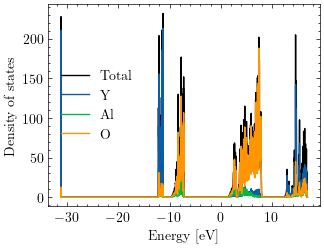

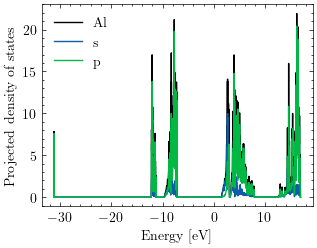

In [25]:
fig, ax = plt.subplots()
plot_dos_total(output, elements=True, ax=ax, ls='solid')
plt.show()

fig, ax = plt.subplots()
plot_dos_species(output, specie='Al', orbitals=True, ax=ax, ls='solid')
plt.show()

# Bands of energy

In [ ]:
def read_output_bands(output_pp, output_bands):
    """
    Read output files of processing band calculations
    to extract valence and conduction bands.
    Args:
    - output_pp: output file of &BANDS/bands.x to extract
                 high-symmetry points (printed information)
    - output_bands: output dat file with bands 
                 likely named XXXXX.dat.gnu
    
    Output:
    - directory with arrays of: kpoints, valence_band, 
      conduction_band, Fermi_energy, high_symmetry_points
    """

    # get high symmetry points
    hs_points = []
    with open(output_pp, 'r') as f:
        for line in f.readlines():
            if line.startswith('     high-symmetry point:'):
                hs_points.append(float(line.split(' ')[-1]))

    # extract bands
    data = np.loadtxt(output_bands)
    k = np.unique(data[:,0])
    _bands = np.reshape(data[:, 1], (-1, len(k)))

    # average energy in a energy level
    ll_band = _bands.mean(axis=1)
    # check for gaps larger than 1eV
    mask = ll_band[1:]-ll_band[:-1] > 1
    # midpoint of energy gap
    gap = (ll_band[1:][mask] + ll_band[:-1][mask])/2
    # define valence band
    valence_band = _bands[(ll_band>gap[-2])&(ll_band<gap[-1]),:]
    # define conduction band
    conduction_band = _bands[(ll_band>gap[-1]),:]
    # get Fermi energy
    eFermi = valence_band.max()

    # print information
    print(f'Fermi energy = {eFermi:.4f} eV')

    print(f'Valence band = [{valence_band.min():.4f},{valence_band.max(): .4f}]')
    idxs = np.where(valence_band==valence_band.max())
    ii, jj = idxs[0], idxs[1]
    for n in range(len(ii)):
        i, j = ii[n], jj[n]
        top_valence = valence_band[i, j]
        print(f'Band {i} k={k[j]:.4f} with {top_valence:.4f} eV')

    print(f'Conduction band = [{conduction_band.min(): .4f}, {conduction_band.max():.4f}]')
    idxs = np.where(conduction_band==conduction_band.min())
    ii, jj = idxs[0], idxs[1]
    for n in range(len(ii)):
        i, j = ii[n], jj[n]
        bottom_conduction =  conduction_band[i, j]
        print(f'Band {i} k={k[j]:.4f} with {bottom_conduction:.4f} eV')

    print(f'Energy gap = {conduction_band.min()-valence_band.max(): .4f} eV')

    output = {'kpoints': k,
              'valence_band': valence_band-eFermi,
              'conduction_band': conduction_band-eFermi,
              'Fermi_energy': eFermi,
              'high_symmetry_points': np.array(hs_points)}

    return output

In [27]:
output_pp = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAG/LDA/YAG.pp.bnd.out'
output_bands = '/home/ahinostrozac/Documents/programs/Research/uni/YAX/results/YAG/LDA/yag_bands.dat.gnu'

output = read_output_bands(output_pp, output_bands)

Fermi energy = 7.9415 eV
Valence band = [1.4561, 7.9415]
Band 141 k=0.0000 with 7.9415 eV
Band 141 k=2.0908 with 7.9415 eV
Band 142 k=0.0000 with 7.9415 eV
Band 142 k=2.0908 with 7.9415 eV
Band 143 k=0.0000 with 7.9415 eV
Band 143 k=2.0908 with 7.9415 eV
Conduction band = [ 12.3904, 16.8503]
Band 0 k=0.0000 with 12.3904 eV
Band 0 k=2.0908 with 12.3904 eV
Energy gap =  4.4489 eV


In [ ]:
def plot_bands(output, ax=None, **kwargs):
    """
    Plot energy bands.
    Args:
    - output: directory with extracted arrays of energy bands
    - ax=None: optional
    - kwargs: for line plots
    """

    if ax is None: fig, ax = plt.subplots(figsize=(5,10))
    else:          fig = ax.figure

    k = output['kpoints']
    vBand = output['valence_band']
    cBand = output['conduction_band']

    # valence band
    for band in range(len(vBand)):
        ax.plot(k, vBand[band], color='k', **kwargs)
    # top of valence band
    idxs = np.where(vBand==vBand.max())
    i, j = idxs[0], idxs[1]
    ax.scatter(k[j], vBand[idxs], marker='o')

    # conduction band
    for band in range(len(cBand)):
        ax.plot(k, cBand[band], color='k', **kwargs)
    # bottom of valence band
    idxs = np.where(cBand==cBand.min())
    i, j = idxs[0], idxs[1]
    ax.scatter(k[j], cBand[idxs], marker='o')

    # high-symmetry points
    location = output['high_symmetry_points']
    style = dict(linewidth=0.75, color='gray', linestyle=':', zorder=1)
    for loc in location[1:-1]:
        ax.axvline(loc, **style)

    ax.axhline(0, **style)
    ax.axhline(cBand[i[0], j[0]], **style)
    ax.set_xticks([])
    ax.set_xlim([np.min(location), np.max(location)])
    ax.set_ylabel('Energía - Energía de Fermi [eV]')
    ax.minorticks_off()

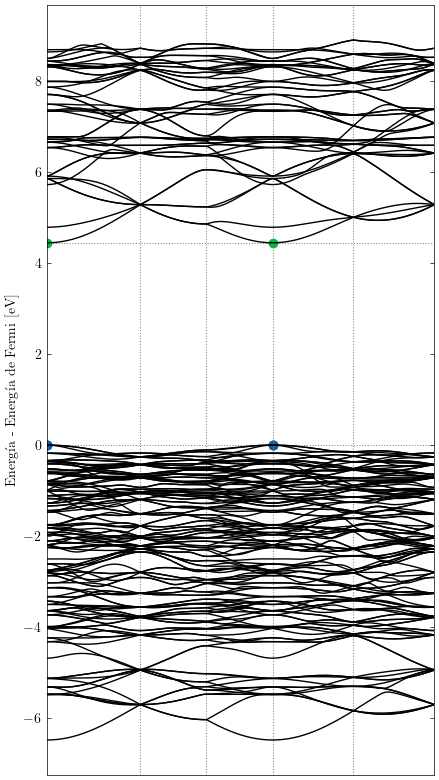

In [30]:
plot_bands(output)